In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import random

%matplotlib inline

## 生成数据集

In [2]:
nums_input=2
nums_examples=1000

true_w = [2, -3.4]
true_b = 4.2

In [3]:
features=torch.randn(nums_examples,nums_input)
features.shape

torch.Size([1000, 2])

In [4]:
labels=true_w[0]*features[:,0]+true_w[1]*features[:,1]+true_b

In [5]:
# 创造噪声
labels+=torch.tensor(np.random.normal(0,0.01,size=labels.size()),dtype=torch.float)

In [6]:
def set_figsize(figsize=(3.5, 2.5)):
    # 设置图的尺寸
    plt.rcParams['figure.figsize'] = figsize

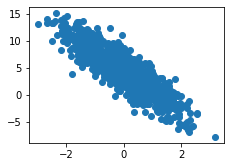

In [7]:
# 画出 第一维特征和第二维特征与label的关系
set_figsize()
x_1=features[:,0]
x_2=features[:,1]
plt.scatter(x_2,labels)

In [8]:
# 定义batch 读取数据
def data_iter(features,labels,batch_size=32):
    num_examples=len(features)
    indices=list(range(num_examples))
    for i in range(0,num_examples,batch_size):
        j=torch.LongTensor(indices[i:min(i+batch_size,num_examples)])
        yield  features.index_select(0, j), labels.index_select(0, j)
        
for X,y in data_iter(features,labels,batch_size=10):
    print("X:\n",X)
    print("y:\n",y)
    break

X:
 tensor([[-6.7375e-01, -1.7972e-01],
        [ 2.3722e-01,  5.3104e-02],
        [-5.7392e-04,  3.7897e-01],
        [ 5.3454e-01, -6.8439e-01],
        [ 1.4191e+00, -1.9244e-01],
        [-2.3654e+00,  3.1178e-01],
        [ 1.0961e+00,  1.7555e+00],
        [-7.3893e-01, -2.1659e-01],
        [-4.6555e-01, -9.4241e-01],
        [-6.0019e-01, -8.4187e-01]])
y:
 tensor([ 3.4544,  4.4860,  2.9169,  7.5909,  7.6982, -1.5973,  0.4323,  3.4576,
         6.4597,  5.8595])


## 初始化模型参数

In [9]:
w=torch.tensor(np.random.normal(0,0.01,size=(nums_input,1)),dtype=torch.float)
b=torch.zeros(1,dtype=torch.float)

In [10]:
w.requires_grad_(requires_grad=True)
b.requires_grad_(requires_grad=True) 

tensor([0.], requires_grad=True)

## 定义模型

In [11]:
def linear_regression(X,w,b):
    return torch.mm(X,w)+b

In [12]:
def squared_loss(y_pred, y):
    return (y_pred - y.view(y_pred.size())) ** 2 / 2

In [13]:
def sgd(params, lr, batch_size):
    for param in params:
        param.data -= lr * param.grad / batch_size # 注意这里更改param时用的param.data

## 训练模型

In [14]:
lr=3e-4
epochs=100
net=linear_regression
loss=squared_loss

from tqdm import trange,tqdm

# pbar=trange(epochs)

for i in tqdm(range(epochs)):
#     pbar.set_description("epoch %s" % i)
    for X,y in data_iter(features,labels,batch_size=10):
        l = loss(net(X, w, b), y).sum()
        l.backward()
        sgd([w, b], lr, batch_size=10)
        
        # 梯度清零
        w.grad.data.zero_()
        b.grad.data.zero_()
        
#         pbar.set_postfix(loss=loss)
# pbar.close()

100%|██████████| 100/100 [00:01<00:00, 50.70it/s]


In [15]:
## 可以看到，这两个内容还是比较相似的
print(true_w, '\n', w)
print(true_b, '\n', b)

[2, -3.4] 
 tensor([[ 1.9172],
        [-3.2665]], requires_grad=True)
4.2 
 tensor([4.0201], requires_grad=True)


# 上面是我们自己定义网络结构以及内容，下面介绍更为通用的方法

## 定义网络层

In [25]:
import torch.nn as nn
class LinearNet(nn.Module):
    def __init__(self,num_feature):
        super(LinearNet,self).__init__()
        self.linear=nn.Linear(num_feature,1)
    def forward(self,x):
        y=self.linear(x)
        return y

In [26]:
net = LinearNet(nums_input)
print(net)

LinearNet(
  (linear): Linear(in_features=2, out_features=1, bias=True)
)


In [27]:
# 查看初始化的参数
for param in net.parameters():
    print(param)

Parameter containing:
tensor([[-0.3882,  0.6774]], requires_grad=True)
Parameter containing:
tensor([0.6994], requires_grad=True)


In [41]:
# 需要初始化的话那么就直接在 from torch.nn import init 这里进行初始化

In [36]:
# 定义损失函数
loss=nn.MSELoss()

In [37]:
# 定义优化算法
import torch.optim as optim

optimizer = optim.Adam(net.parameters(), lr=3e-3)

In [38]:
print(optimizer)

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.003
    weight_decay: 0
)


In [40]:
num_epochs = 10
for epoch in range(1, num_epochs + 1):
    for X, y in data_iter(features,labels,batch_size=10):
        output = net(X)
        l = loss(output, y)
        optimizer.zero_grad() # 梯度清零，等价于net.zero_grad()
        l.backward()
        optimizer.step()
    print('epoch %d, loss: %f' % (epoch, l.item()))

/Users/litao/.pip/env/python3/DL/lib/python3.7/site-packages/torch/nn/modules/loss.py:443: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


epoch 1, loss: 33.606285
epoch 2, loss: 32.441498
epoch 3, loss: 31.541798
epoch 4, loss: 30.851830
epoch 5, loss: 30.324406
epoch 6, loss: 29.923332
epoch 7, loss: 29.622149
epoch 8, loss: 29.401886
epoch 9, loss: 29.248808
epoch 10, loss: 29.152472
